In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
df=pd.read_csv(r"/content/drive/MyDrive/complete_dataset.csv")
df

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2020-10-02,99585.835,-6.076028,41988.240,26.980251,57597.595,-30.173823,0.625000,12.8,26.0,22.0,0.0,N,N
2102,2020-10-03,92277.025,-1.983471,44133.510,32.438156,48143.515,-33.538025,0.583333,17.4,29.4,19.8,0.0,N,N
2103,2020-10-04,94081.565,25.008614,88580.995,26.571687,5500.570,-0.163066,0.062500,13.5,29.5,8.4,0.0,N,N
2104,2020-10-05,113610.030,36.764701,106587.375,39.616015,7022.655,-6.511550,0.083333,9.1,12.7,7.3,12.8,N,N


In [3]:
df.columns = df.columns.str.strip()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             2106 non-null   object 
 1   demand           2106 non-null   float64
 2   RRP              2106 non-null   float64
 3   demand_pos_RRP   2106 non-null   float64
 4   RRP_positive     2106 non-null   float64
 5   demand_neg_RRP   2106 non-null   float64
 6   RRP_negative     2106 non-null   float64
 7   frac_at_neg_RRP  2106 non-null   float64
 8   min_temperature  2106 non-null   float64
 9   max_temperature  2106 non-null   float64
 10  solar_exposure   2105 non-null   float64
 11  rainfall         2103 non-null   float64
 12  school_day       2106 non-null   object 
 13  holiday          2106 non-null   object 
dtypes: float64(11), object(3)
memory usage: 230.5+ KB


In [5]:
# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 date               0
demand             0
RRP                0
demand_pos_RRP     0
RRP_positive       0
demand_neg_RRP     0
RRP_negative       0
frac_at_neg_RRP    0
min_temperature    0
max_temperature    0
solar_exposure     1
rainfall           3
school_day         0
holiday            0
dtype: int64


In [6]:
# Summary statistics
df.describe(include='all')

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
count,2106,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2105.000000,2103.000000,2106,2106
unique,2106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,N
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1453,2029
mean,NaN,120035.476503,76.079554,119252.305055,76.553847,783.171448,-2.686052,0.008547,11.582289,20.413200,14.743373,1.505944,NaN,NaN
std,NaN,13747.993761,130.246805,14818.631319,130.114184,3578.920686,19.485432,0.039963,4.313711,6.288693,7.945527,4.307897,NaN,NaN
min,NaN,85094.375000,-6.076028,41988.240000,13.568986,0.000000,-342.220000,0.000000,0.600000,9.000000,0.700000,0.000000,NaN,NaN
25%,NaN,109963.650000,38.707040,109246.250000,39.117361,0.000000,0.000000,0.000000,8.500000,15.525000,8.200000,0.000000,NaN,NaN
50%,NaN,119585.912500,66.596738,119148.082500,66.869058,0.000000,0.000000,0.000000,11.300000,19.100000,12.700000,0.000000,NaN,NaN
75%,NaN,130436.006250,95.075012,130119.477500,95.130181,0.000000,0.000000,0.000000,14.600000,23.900000,20.700000,0.800000,NaN,NaN


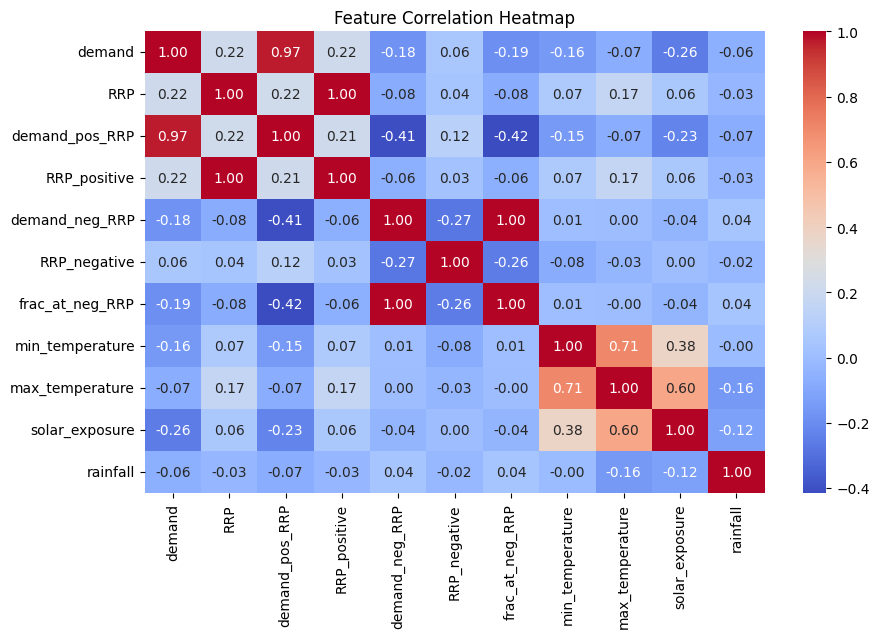

In [7]:
# Correlation heatmap (to see relationships between numerical features)
plt.figure(figsize=(10, 6))
# Select only numerical features for correlation calculation
numerical_df = df.select_dtypes(include=np.number)
sns.heatmap(numerical_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

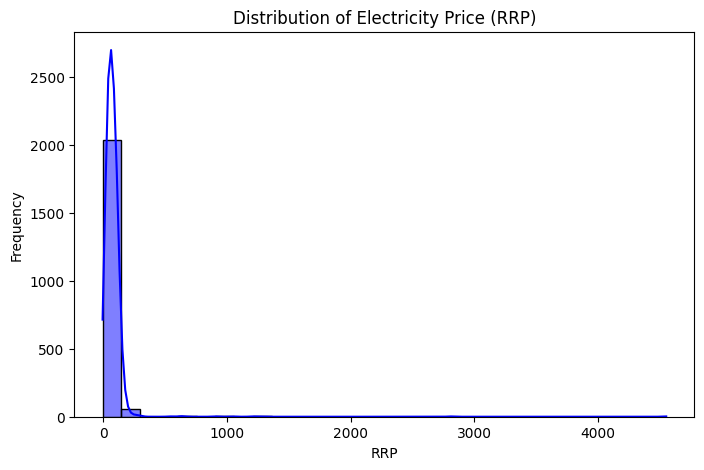

In [8]:
# Distribution of RRP (Electricity Price)
plt.figure(figsize=(8, 5))
sns.histplot(df["RRP"], bins=30, kde=True, color='blue')
plt.title("Distribution of Electricity Price (RRP)")
plt.xlabel("RRP")
plt.ylabel("Frequency")
plt.show()

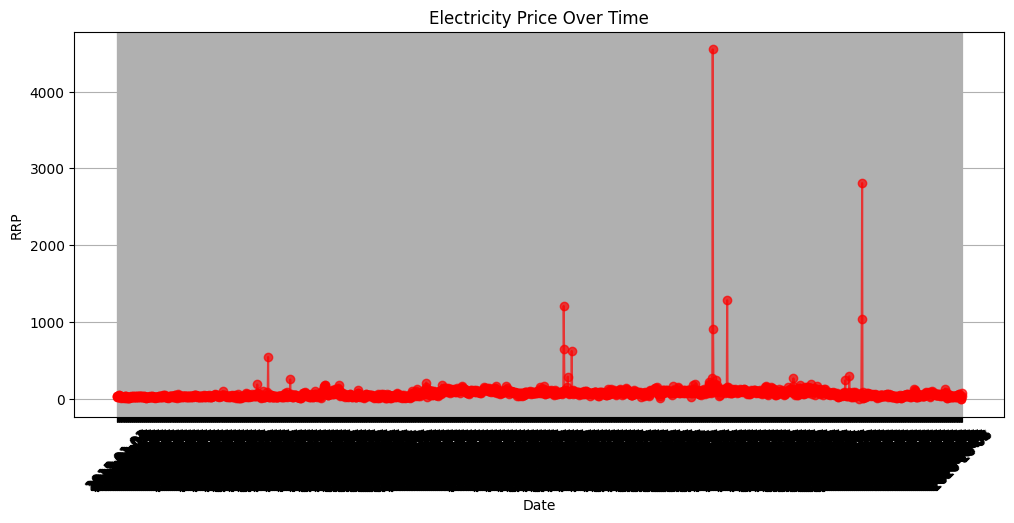

In [9]:
# Time Series Trend of Electricity Prices
plt.figure(figsize=(12, 5))
plt.plot(df["date"], df["RRP"], marker="o", linestyle="-", color="red", alpha=0.7)
plt.title("Electricity Price Over Time")
plt.xlabel("Date")
plt.ylabel("RRP")
plt.xticks(rotation=45)
plt.grid()
plt.show()

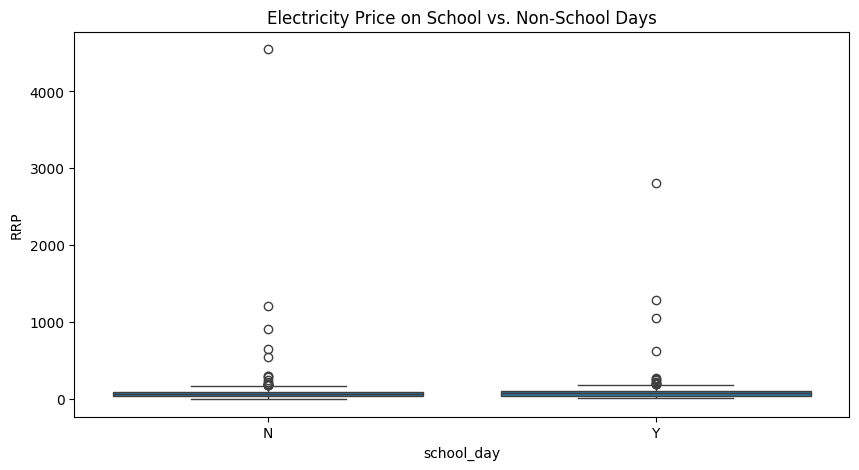

In [10]:
# Boxplot of RRP across school days and holidays
plt.figure(figsize=(10, 5))
sns.boxplot(x="school_day", y="RRP", data=df)
plt.title("Electricity Price on School vs. Non-School Days")
plt.show()

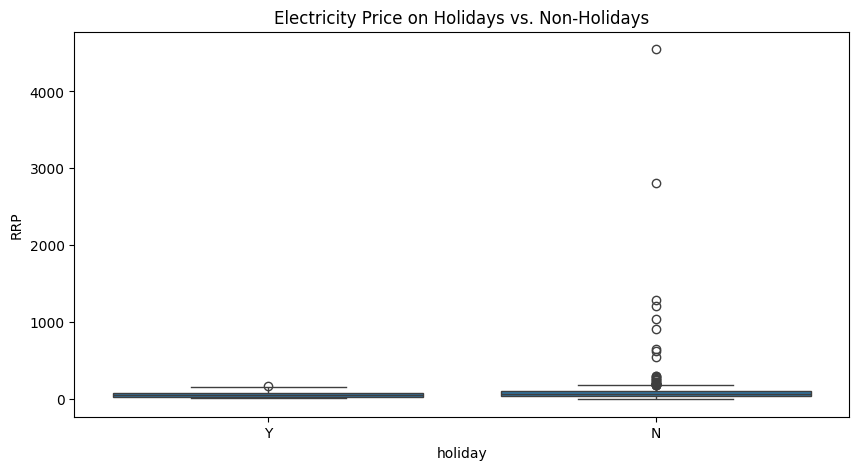

In [11]:
plt.figure(figsize=(10, 5))
sns.boxplot(x="holiday", y="RRP", data=df)
plt.title("Electricity Price on Holidays vs. Non-Holidays")
plt.show()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             2106 non-null   object 
 1   demand           2106 non-null   float64
 2   RRP              2106 non-null   float64
 3   demand_pos_RRP   2106 non-null   float64
 4   RRP_positive     2106 non-null   float64
 5   demand_neg_RRP   2106 non-null   float64
 6   RRP_negative     2106 non-null   float64
 7   frac_at_neg_RRP  2106 non-null   float64
 8   min_temperature  2106 non-null   float64
 9   max_temperature  2106 non-null   float64
 10  solar_exposure   2105 non-null   float64
 11  rainfall         2103 non-null   float64
 12  school_day       2106 non-null   object 
 13  holiday          2106 non-null   object 
dtypes: float64(11), object(3)
memory usage: 230.5+ KB


In [13]:
df

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2020-10-02,99585.835,-6.076028,41988.240,26.980251,57597.595,-30.173823,0.625000,12.8,26.0,22.0,0.0,N,N
2102,2020-10-03,92277.025,-1.983471,44133.510,32.438156,48143.515,-33.538025,0.583333,17.4,29.4,19.8,0.0,N,N
2103,2020-10-04,94081.565,25.008614,88580.995,26.571687,5500.570,-0.163066,0.062500,13.5,29.5,8.4,0.0,N,N
2104,2020-10-05,113610.030,36.764701,106587.375,39.616015,7022.655,-6.511550,0.083333,9.1,12.7,7.3,12.8,N,N


In [14]:
df['date'] = pd.to_datetime(df['date'])

In [15]:
df

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2020-10-02,99585.835,-6.076028,41988.240,26.980251,57597.595,-30.173823,0.625000,12.8,26.0,22.0,0.0,N,N
2102,2020-10-03,92277.025,-1.983471,44133.510,32.438156,48143.515,-33.538025,0.583333,17.4,29.4,19.8,0.0,N,N
2103,2020-10-04,94081.565,25.008614,88580.995,26.571687,5500.570,-0.163066,0.062500,13.5,29.5,8.4,0.0,N,N
2104,2020-10-05,113610.030,36.764701,106587.375,39.616015,7022.655,-6.511550,0.083333,9.1,12.7,7.3,12.8,N,N


In [16]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
le = LabelEncoder()

# List of columns that are of type 'object' (categorical features)
object_cols = df.select_dtypes(include=['object']).columns

# Convert all object-type columns to string (to handle mixed types)
for col in object_cols:
    df[col] = df[col].astype(str)  # Ensure all data in the column is treated as string

# Apply label encoding to each object-type column
for col in object_cols:
    df[col] = le.fit_transform(df[col])

# Check the result (first few rows)
print(df.head())

        date      demand        RRP  demand_pos_RRP  RRP_positive  \
0 2015-01-01   99635.030  25.633696       97319.240     26.415953   
1 2015-01-02  129606.010  33.138988      121082.015     38.837661   
2 2015-01-03  142300.540  34.564855      142300.540     34.564855   
3 2015-01-04  104330.715  25.005560      104330.715     25.005560   
4 2015-01-05  118132.200  26.724176      118132.200     26.724176   

   demand_neg_RRP  RRP_negative  frac_at_neg_RRP  min_temperature  \
0        2315.790     -7.240000         0.020833             13.3   
1        8523.995    -47.809777         0.062500             15.4   
2           0.000      0.000000         0.000000             20.0   
3           0.000      0.000000         0.000000             16.3   
4           0.000      0.000000         0.000000             15.0   

   max_temperature  solar_exposure  rainfall  school_day  holiday  
0             26.9            23.6       0.0           0        1  
1             38.8            26.8

In [17]:
df.isnull().sum()

,0
date,0
demand,0
RRP,0
demand_pos_RRP,0
RRP_positive,0
demand_neg_RRP,0
RRP_negative,0
frac_at_neg_RRP,0
min_temperature,0
max_temperature,0


In [18]:
# Handling missing values (Fill with median or drop rows)
df.fillna(df.median(), inplace=True)  # Using median for numerical columns

In [19]:
df.isnull().sum()

,0
date,0
demand,0
RRP,0
demand_pos_RRP,0
RRP_positive,0
demand_neg_RRP,0
RRP_negative,0
frac_at_neg_RRP,0
min_temperature,0
max_temperature,0


In [20]:
# Define Features (X) and Target Variable (y)
X = df.drop(columns=["date", "RRP"])  # Drop 'date' and target variable
y = df["RRP"]  # Target variable

In [21]:
# Print shape of data
print(f"Feature Matrix Shape: {X.shape}")
print(f"Target Variable Shape: {y.shape}")

Feature Matrix Shape: (2106, 12)
Target Variable Shape: (2106,)


In [23]:
from sklearn.preprocessing import MinMaxScaler
import joblib
# Initialize scaler
scaler = MinMaxScaler()

# Fit and transform feature matrix
X_scaled = scaler.fit_transform(X)
# Save the trained scaler to a file
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [24]:
from sklearn.model_selection import train_test_split

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)


In [25]:
import numpy as np

# Reshape input for LSTM (samples, timesteps, features)
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [26]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Reshape, Input

# Define Input Shape
input_shape = (1, X_train.shape[1])  # (timesteps, features)

# Input layer
inputs = Input(shape=input_shape)

# AlexNet-inspired Convolutional Layers
x = Reshape((1, X_train.shape[1], 1))(inputs)  # Reshape for Conv2D
x = Conv2D(64, (1, 1), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Flatten()(x)

# LSTM Layer
x = Reshape((1, -1))(x)  # Reshape back for LSTM
x = LSTM(50, return_sequences=False)(x)

# Fully Connected Layers
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(1)(x)  # Output Layer

# Create Model
model = Model(inputs=inputs, outputs=output)

# Compile Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1, 12)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 12, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 1, 12, 64)           │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 1, 12, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 1, 768)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 50)                  │         163,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 169,305 (661.35 KB)

 Trainable params: 169,305 (661.35 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_data=(X_test_lstm, y_test),
                    callbacks=[early_stopping])


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 8862.2764 - mae: 69.0118 - val_loss: 23090.5801 - val_mae: 43.9286
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7031.1934 - mae: 39.8627 - val_loss: 21495.8867 - val_mae: 43.4717
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 16517.6680 - mae: 37.6548 - val_loss: 21331.4570 - val_mae: 37.7995
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7941.9565 - mae: 35.0176 - val_loss: 21382.0566 - val_mae: 40.9083
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11080.6025 - mae: 35.7916 - val_loss: 21301.1445 - val_mae: 39.3464
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5706.8657 - mae: 34.1986 - val_loss: 21286.2891 - val_mae: 40.5349
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14236.1816 - mae: 36.8360 - val_loss: 21010.4707 - val_mae: 36.3560
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4292.6050 - mae: 33.7331 - val_loss: 20991.7402 - val_ma

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict on test data
y_pred = model.predict(X_test_lstm)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Mean Squared Error (MSE): 26.5106
Mean Absolute Error (MAE): 3.2302
Root Mean Squared Error (RMSE): 5.1488
R-squared (R²): 0.9988


In [29]:
import pandas as pd

# Convert predictions to a 1D array
y_pred_flat = y_pred.flatten()

# Create a DataFrame to display results
comparison_df = pd.DataFrame({'Actual': y_test[:10], 'Predicted': y_pred_flat[:10]})

# Print the first 10 comparisons
print(comparison_df)

          Actual   Predicted
1684  163.361637  164.063370
1685  267.347650  296.149658
1686  123.852142  126.416649
1687   76.350981   78.245186
1688  100.011592  102.317894
1689   75.491413   78.602699
1690   52.024493   54.486675
1691   81.723625   83.406883
1692   61.926547   63.894325
1693   54.386880   58.067528


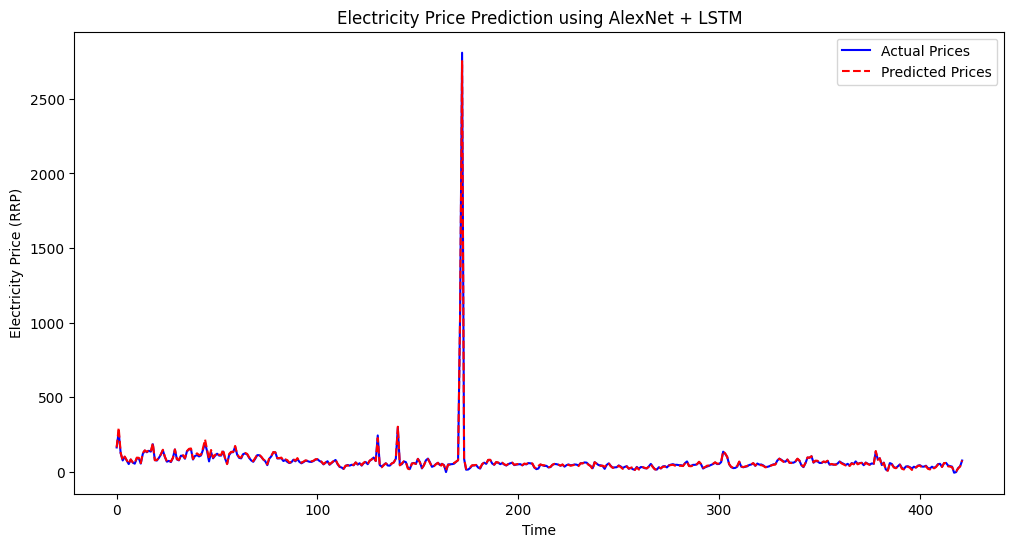

In [30]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual Prices", color='blue')
plt.plot(y_pred, label="Predicted Prices", color='red', linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Electricity Price (RRP)")
plt.title("Electricity Price Prediction using AlexNet + LSTM")
plt.legend()
plt.show()


In [31]:
import joblib

# Save the trained model as a .pkl file
joblib.dump(model, 'electricity_price_model.pkl')

print("Model saved successfully!")


Model saved successfully!


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define Optimized RNN Model
model = Sequential([
    SimpleRNN(128, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.003), input_shape=(1, X_train.shape[1])),
    BatchNormalization(),
    Dropout(0.5),  # Higher dropout to prevent overfitting

    SimpleRNN(64, activation='tanh', return_sequences=False, kernel_regularizer=l2(0.003)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(32),
    LeakyReLU(alpha=0.01),  # LeakyReLU instead of ReLU
    Dense(1)  # Output layer
])

# Compile Model with Learning Rate Decay
optimizer = Adam(learning_rate=0.001)  # Start with 0.001
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)  # Reduce LR when no improvement

# Train the Model
history = model.fit(X_train_lstm, y_train, epochs=200, batch_size=32,
                    validation_data=(X_test_lstm, y_test), verbose=1,
                    callbacks=[early_stopping, reduce_lr])

# Predict on Test Data
y_pred = model.predict(X_test_lstm)

# Evaluate Model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 31191.6230 - mae: 81.0074 - val_loss: 26241.0781 - val_mae: 69.9025 - learning_rate: 0.0010
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 63157.5664 - mae: 83.7506 - val_loss: 25763.2344 - val_mae: 66.2869 - learning_rate: 0.0010
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41408.3359 - mae: 71.6451 - val_loss: 24888.1250 - val_mae: 57.7686 - learning_rate: 0.0010
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25744.1660 - mae: 57.3708 - val_loss: 23665.3711 - val_mae: 45.3721 - learning_rate: 0.0010
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12101.3477 - mae: 44.8145 - val_loss: 22715.7441 - val_mae: 40.3804 - learning_rate: 0.0010
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4974.6040 - mae: 37.8856 - val_loss: 22254.2852 - val_mae: 39.6965 - learning_rate: 0.0010
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 44883.7578 - mae: 46.4383 - val_loss: 21889.144

In [33]:
import pandas as pd

# Convert predictions to a 1D array
y_pred_flat = y_pred.flatten()

# Create a DataFrame to display results
comparison_df = pd.DataFrame({'Actual': y_test[:10], 'Predicted': y_pred_flat[:10]})

# Print the first 10 comparisons
print(comparison_df)


          Actual   Predicted
1684  163.361637  129.688492
1685  267.347650  338.473877
1686  123.852142   94.261986
1687   76.350981   56.640766
1688  100.011592   65.891342
1689   75.491413   55.723019
1690   52.024493   49.607063
1691   81.723625   61.965633
1692   61.926547   53.745945
1693   54.386880   22.442978


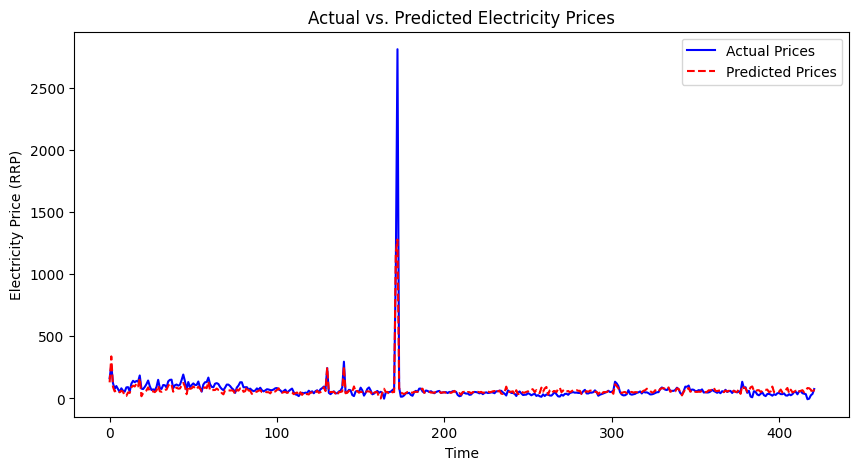

In [34]:
import matplotlib.pyplot as plt

# Convert predictions to 1D array
y_pred = y_pred.flatten()

# Plot Actual vs. Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual Prices", color='blue')
plt.plot(y_pred, label="Predicted Prices", color='red', linestyle='dashed')

# Labels and Title
plt.xlabel("Time")
plt.ylabel("Electricity Price (RRP)")
plt.title("Actual vs. Predicted Electricity Prices")
plt.legend()
plt.show()


In [35]:
import joblib

# Save the trained model as a .pkl file
joblib.dump(model, 'rnn_model.pkl')

print("Model saved successfully!")

Model saved successfully!


In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build ANN Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer for price prediction
])

# Compile Model
model.compile(optimizer='adam', loss='mse')

# Train the Model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predict on Test Data
y_pred = model.predict(X_test)

# Evaluate Model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 31723.3281 - val_loss: 20680.4570
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9934.0986 - val_loss: 20404.3535
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4246.9473 - val_loss: 20128.0156
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20940.8418 - val_loss: 20007.1074
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8403.4004 - val_loss: 19787.1816
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11364.4785 - val_loss: 19498.2969
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13429.4111 - val_loss: 19398.9004
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12894.4268 - val_loss: 19146.7969
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5094.5107 - val_loss: 18554.2949
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5157.8799 - val_loss: 18014.9434
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6462

In [37]:
import pandas as pd

# Convert predictions to a 1D array
y_pred_flat = y_pred.flatten()

# Create a DataFrame to display results
comparison_df = pd.DataFrame({'Actual': y_test[:10], 'Predicted': y_pred_flat[:10]})

# Print the first 10 comparisons
print(comparison_df)

          Actual   Predicted
1684  163.361637  171.820786
1685  267.347650  255.826096
1686  123.852142  133.179123
1687   76.350981   85.615097
1688  100.011592  109.278084
1689   75.491413   85.336647
1690   52.024493   61.694870
1691   81.723625   91.414818
1692   61.926547   71.172211
1693   54.386880   63.917393


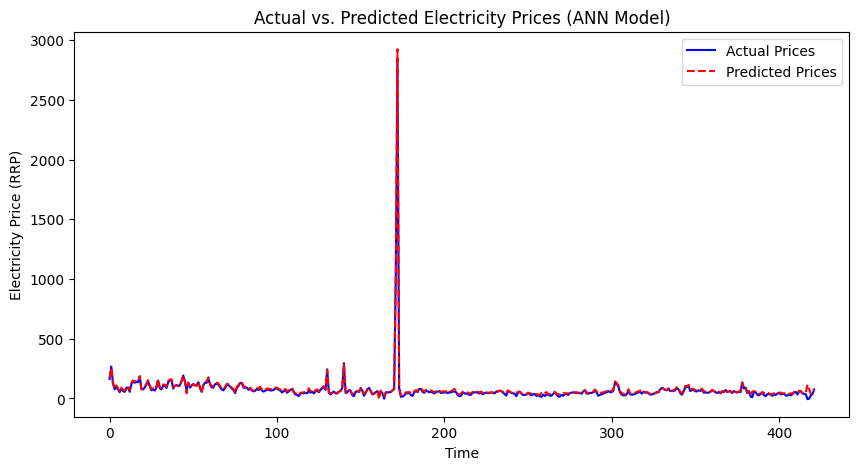

In [38]:
import matplotlib.pyplot as plt

# Convert predictions to 1D array
y_pred = y_pred.flatten()

# Plot Actual vs. Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual Prices", color='blue')
plt.plot(y_pred, label="Predicted Prices", color='red', linestyle='dashed')

# Labels and Title
plt.xlabel("Time")
plt.ylabel("Electricity Price (RRP)")
plt.title("Actual vs. Predicted Electricity Prices (ANN Model)")
plt.legend()
plt.show()


In [39]:
import joblib

# Save the trained model as a .pkl file
joblib.dump(model, 'ann_model.pkl')

print("Model saved successfully!")

Model saved successfully!
